In [13]:
!pip install pyDOE

In [1]:
import tensorflow as tf
import datetime, os
#hide tf logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import seaborn as sns 
import codecs, json

# generates same random numbers each time
np.random.seed(1234)
tf.random.set_seed(1234)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.8.0


# *Data Prep*

Training and Testing data is prepared from the solution file

In [159]:
from scipy.stats import multivariate_normal
#getting collocation points
x = np.linspace(-1, 1, 128)                     # 256 points between -1 and 1 [256x1]
y = np.linspace(-1, 1, 128)
t = np.linspace(0, 1, 100)                    # 100 time points between 0 and 1 [100x1]
X, Y, T = np.meshgrid(x, y ,t) 
usol=np.zeros((128, 128 ,len(t)))
pos = np.dstack((X[:,:,0], Y[:,:,0]))
rv = multivariate_normal(mean=[0.0 , 0.0], cov=[0.05 , 0.05])
usol[:][:,:,0] = rv.pdf(pos)

#collocation points for every position and every time



# *Test Data*

We prepare the test data to compare against the solution produced by the PINN.

In [160]:
''' X_u_test = [X[i],T[i]] [25600,2] for interpolation'''
X_u_test = np.hstack((X.flatten()[:,None], Y.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_u_test[0]  # [-1. 0.]
ub = X_u_test[-1] # [1.  0.99]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
u = usol.flatten('F')[:,None] 

# *Training Data*

The boundary conditions serve as the test data for the PINN and the collocation points are generated using **Latin Hypercube Sampling**

In [161]:
def trainingdata(N_u,N_f):

    '''Boundary Conditions'''

    #Initial Condition -1 =< x,y =<1 and t = 0  
    initial_xy = np.hstack((np.vstack(X[:,:,0][:,:,None]), np.vstack(Y[:,:,0][:,:,None]) ,np.vstack(T[:,:,0][:,:,None]))) #L1
    initial_u = np.vstack(usol[:][:,:,0][:,:,None])

    #Boundary Condition -1 < x < 1, y = -1 and 0 =< t =<1
    bottomedge_xy = np.hstack((np.tile(X[0,:,0], len(t))[:,None], np.tile(Y[0,:,0], len(t))[:,None], np.hstack((np.tile(T[0,0,:][:,None], 128)))[:,None])) #L2
    bottomedge_u = np.tile(usol[:,-1,-1], len(t))[:,None]

    #Boundary Condition -1 < x < 1, y = 1 and 0 =< t =<1
    topedge_xy = np.hstack((np.tile(X[0,:,0], len(t))[:,None], np.tile(Y[-1,:,0], len(t))[:,None], np.hstack((np.tile(T[0,0,:][:,None], 128)))[:,None])) #L3
    topedge_u = np.tile(usol[:,-1,-1], len(t))[:,None]
    
    #Boundary Condition x = -1, -1 < y < 1 and 0 =< t =<1
    leftedge_xy = np.hstack((np.tile(X[:,0,0], len(t))[:,None], np.tile(Y[:,0,0], len(t))[:,None], np.hstack((np.tile(T[0,0,:][:,None], 128)))[:,None])) #L4
    leftedge_u = np.tile(usol[:,-1,-1], len(t))[:,None]

    #Boundary Condition x = 1, -1 < y < 1 and 0 =< t =<1
    rightedge_xy = np.hstack((np.tile(X[:,-1,0], len(t))[:,None], np.tile(Y[:,0,0], len(t))[:,None], np.hstack((np.tile(T[0,0,:][:,None], 128)))[:,None])) #L5
    rightedge_u = np.tile(usol[:,-1,-1], len(t))[:,None]

    all_X_u_train = np.vstack([initial_xy, bottomedge_xy, topedge_xy, leftedge_xy, rightedge_xy]) # X_u_train [456,2] (456 = 256(L1)+100(L2)+100(L3))
    all_u_train = np.vstack([initial_u, bottomedge_u, topedge_u, leftedge_u, rightedge_u])   #corresponding u [456x1]

    #choose random N_u points for training
    idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) 

    X_u_train = all_X_u_train[idx, :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[idx,:]      #choose corresponding u

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
    X_f_train = lb + (ub-lb)*lhs(3,N_f) 
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 
    return X_f_train, X_u_train, u_train 


# **PINN**

Generate a **PINN** of L hidden layers, each with n neurons. 

Initialization: ***Xavier***

Activation: *tanh (x)*

In [184]:
class Sequentialmodel(tf.Module): 
    def __init__(self, layers, name=None):
        self.itera = 0
        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters
        
        for i in range(len(layers)-1):
            
            input_dim = layers[i]
            output_dim = layers[i+1]
            
            #Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
                       
            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))
                    
            self.W.append(w)
            self.W.append(b)
            
            self.parameters +=  input_dim * output_dim + output_dim
    
    def evaluate(self,x):
        
        x = (x-lb)/(ub-lb)
        
        a = x
        
        for i in range(len(layers)-2):
            
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
            
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        return a
    
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 

            
    def loss_BC(self,x,y):

        loss_u = tf.reduce_mean(tf.square(y-self.evaluate(x)))
        return loss_u

    def loss_PDE(self, x_to_train_f):
    
        g = tf.Variable(x_to_train_f, dtype = 'float64', trainable = False)
    
        a = 20
        b = 5
        sigma2=0.25

        x_f = g[:,0:1]
        y_f = g[:,1:2]
        t_f = g[:,2:3]

        with tf.GradientTape(persistent=True) as tape:

            tape.watch(x_f)
            tape.watch(y_f)
            tape.watch(t_f)

            g = tf.stack([x_f[:,0], y_f[:,0], t_f[:,0]], axis=1)   

            z = self.evaluate(g)
            p_x = tape.gradient(z,x_f)
            p_y = tape.gradient(z,y_f)

        p_t = tape.gradient(z,t_f)    
        p_xx = tape.gradient(p_x, x_f)
        p_yy = tape.gradient(p_y, y_f)
        p_xy = tape.gradient(p_x, y_f)
        p_yx = tape.gradient(p_y, x_f)

        del tape

        p=self.evaluate(g)

        #f = p_t - sigma2/2*p_xx - sigma2/2*p_yy # diffusion equation
        #f = p_t + (a - 3*b*x_f**2 - b*y_f**2)*z + (a*x_f - b*(x_f**2 + y_f**2)*x_f)*p_x + (a - b*x_f**2 - 3*b*y_f**2)*z + (a*y_f - b*(x_f**2 + y_f**2)*y_f)*p_y - sigma2/2*(p_xx + p_xy + p_yy) #mexican hat potential
        #f = p_t - 3*b*(x_f**2+y_f**2)*z + a*z + p_x*(b*x_f**3 - a*x_f) + p_y*(b*y_f**3 - a*y_f) + sigma2/2*(p_xx + p_yy) # double wave
        f = p_t - a * x_f * p_x - sigma2/2*p_xx - 2*a * y_f * p_y - sigma2*p_yy
        #f = p_t - (p_yy + p_xx)*sigma2/2
        
        loss_f = tf.reduce_mean(tf.square(f))

        return loss_f
    
    def loss(self,x,y,g):

        loss_u = self.loss_BC(x,y)
        loss_f = self.loss_PDE(g)

        loss = loss_u + loss_f

        return loss, loss_u, loss_f
    
    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            loss_val, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train)
            
        grads = tape.gradient(loss_val,self.trainable_variables)
                
        del tape
        
        grads_1d = [ ] #flatten grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases

        return loss_val.numpy(), grads_1d.numpy()
    
    def optimizer_callback(self,parameters):
               
        loss_value, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train)
        
        u_pred = self.evaluate(X_u_test)
        error_vec = np.linalg.norm((u-u_pred),2)/np.linalg.norm(u,2)
        
        tf.print(self.itera, loss_value, loss_u, loss_f, error_vec)
        self.itera +=1

# *Solution Plot*

In [185]:
def solutionplot(u_pred,X_u_train,u_train):
    
    fig, ax = plt.subplots()
    ax.axis('off')

    gs0 = gridspec.GridSpec(2, 3)
    gs0.update(top=1, bottom=0, left=0.1, right=2, wspace=0.3, hspace =0.4)
    ax = plt.subplot(gs0[0, :])

    h = ax.imshow(u_pred, interpolation='nearest', cmap='rainbow', 
                extent=[T.min(), T.max(), X.min(), X.max()], 
                origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    
    ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 4, clip_on = False)

    line = np.linspace(x.min(), x.max(), 2)[:,None]
    #ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
    #ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
    #ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)    

    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.legend(frameon=False, loc = 'best')
    ax.set_title('$u(x,t)$', fontsize = 10)
    
    ''' 
    Slices of the solution at points t = 0.25, t = 0.50 and t = 0.75
    '''
    
    ####### Row 1: u(t,x) slices ##################
    #gs1 = gridspec.GridSpec(1, 3)
    #gs1.update(top=0.3, bottom=-0.1, left=0.1, right=2, wspace=0.5)

    ax = plt.subplot(gs0[1, 0])
    #ax.plot(x,usol.T[0,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,u_pred.T[0,:], 'r', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')    
    ax.set_title('$t = 0.s$', fontsize = 10)
    #ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-0.1,9])

    ax = plt.subplot(gs0[1, 1])
    #ax.plot(x,usol.T[50,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,u_pred.T[500,:], 'r', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')
    #ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-0.1,9])
    ax.set_title('$t = 0.1s$', fontsize = 10)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

    ax = plt.subplot(gs0[1, 2])
    #ax.plot(x,usol.T[75,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,u_pred.T[750,:], 'r', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')
    #ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-0.1,9])    
    ax.set_title('$t = 0.15s$', fontsize = 10)
    
    #plt.tight_layout()
    plt.savefig('Ornstein-Uhlenbeck.png',dpi = 500)   

# *Model Training and Testing*

A function '**model**' is defined to generate a NN as per the input set of hyperparameters, which is then trained and tested. The L2 Norm of the solution error is returned as a comparison metric

In [186]:
N_u = 20000 #Total number of data points for 'u'
N_f = 10000 #Total number of collocation points 

# Training data
X_f_train, X_u_train, u_train = trainingdata(N_u, N_f)

layers = np.array([3,20,20,20,20,20,20,20,20,1]) #8 hidden layers

PINN = Sequentialmodel(layers)

init_params = PINN.get_weights().numpy()

start_time = time.time() 

# train the model with Scipy L-BFGS optimizer
results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 200, 
                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 5e-8, 
                                            'maxfun':  50000, 
                                            'maxiter': 500,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})

elapsed = time.time() - start_time                
print('Training time: %.2f' % (elapsed))

print(results)

PINN.set_weights(results.x)

''' Model Accuracy ''' 
u_pred = PINN.evaluate(X_u_test)

error_vec = np.linalg.norm((u-u_pred),2)/np.linalg.norm(u,2)        # Relative L2 Norm of the error (Vector)
print('Test Error: %.5f'  % (error_vec))

#u_pred = np.reshape(u_pred,(256,1000),order='F')                        # Fortran Style ,stacked column wise!

''' Solution Plot '''
#solutionplot(u_pred,X_u_train,u_train)

0 30.193515362729098 0.12823218646319229 30.065283176265904 2.652464357038353
1 0.82151567765779 0.089591269805792031 0.731924407851998 1.422770190863929
2 0.75149945987664335 0.089921392127345262 0.66157806774929806 1.373671781552627
3 0.55601112877803693 0.094212397152758018 0.4617987316252789 1.3867940010429747
4 0.45780108052888713 0.097343743167862137 0.360457337361025 1.507371935702007
5 0.33818547790684172 0.10036255318599532 0.2378229247208464 1.6263251240690795
6 0.25996398220627304 0.098994509087424132 0.16096947311884888 1.5153825299097277
7 0.17441529667896788 0.096013728622859645 0.07840156805610822 1.2889257218674095
8 0.12744589970899226 0.093588921074058459 0.0338569786349338 1.1629400709720341
9 0.11534336595699919 0.092726998662242585 0.02261636729475661 1.1481629879972919
10 0.10810873776832167 0.092417308366419912 0.015691429401901762 1.168748512864576
11 0.10444661238178657 0.092504164913501288 0.011942447468285282 1.2024692992696742
12 0.1010907116316918 0.0928936

88 0.092863883346609249 0.091382794823358648 0.0014810885232506006 1.355948940332814
89 0.092863250060113187 0.091368157171107439 0.0014950928890057412 1.3579276180850754
90 0.092862577903813373 0.091360620743455023 0.0015019571603583528 1.3593980803106112
91 0.092860364963922776 0.091345631923892431 0.0015147330400303418 1.3614545815921917
92 0.09285183181104166 0.09130767358669005 0.0015441582243516088 1.3660234876743518
93 0.092839558576339784 0.091282021619505216 0.0015575369568345708 1.369071957317455
94 0.09281414083204545 0.09127962054661555 0.0015345202854299036 1.3698852310342513
95 0.092794554049046449 0.091326931831588576 0.001467622217457872 1.362894477546674
96 0.092783772079690449 0.091377081563720555 0.0014066905159698904 1.3550713816372806
97 0.092776231754113869 0.09138166443270157 0.0013945673214123056 1.3528728442648315
98 0.092773540425798967 0.091392292863811009 0.0013812475619879583 1.3514556994145857
99 0.092771017292183316 0.091368968785403584 0.0014020485067797

184 0.0919019856434862 0.090472810706953413 0.0014291749365327882 1.4000595140268357
185 0.0918864984530805 0.090450425854281452 0.001436072598799046 1.3903160532415684
186 0.0918717453090647 0.090479820473995637 0.0013919248350690605 1.390010338131337
187 0.091866211429887962 0.090465768114858139 0.0014004433150298175 1.396393279679555
188 0.091859704239938389 0.090440477947230619 0.0014192262927077643 1.3982193686417765
189 0.09185475221246206 0.090417966032767638 0.0014367861796944277 1.3990922261291376
190 0.091853574387612977 0.090403961196219421 0.0014496131913935529 1.4027871899802224
191 0.091849306784232393 0.090423155112764192 0.0014261516714681956 1.4011030075351498
192 0.091847456961095378 0.0904041393920667 0.0014433175690286711 1.4030076861714278
193 0.091845826791966817 0.0904069978440124 0.0014388289479544058 1.4029038248632142
194 0.091844439286462812 0.090403877997623422 0.0014405612888393946 1.401948465813776
195 0.091843354230770627 0.0904020504853424 0.001441303745

280 0.091135964683571241 0.089818764342518828 0.001317200341052408 1.402220918246967
281 0.09111596294300367 0.089808236440457989 0.001307726502545683 1.4027984146350458
282 0.091100923845956638 0.089825224759132988 0.0012756990868236482 1.4000300487914434
283 0.091084627986593364 0.089813072977534644 0.0012715550090587205 1.3985696758241792
284 0.091069869224357558 0.089784558243660356 0.0012853109806972055 1.396639194761708
285 0.091057642486082252 0.089754683146702818 0.0013029593393794362 1.4013772707834766
286 0.09104473587574835 0.08972913586098881 0.0013156000147595411 1.4085087844215254
287 0.091035553340683861 0.08969619771038069 0.0013393556303031775 1.4149056274812408
288 0.09102818429887756 0.089666171823469379 0.0013620124754081862 1.4193067248781641
289 0.09102603431215138 0.08960724442609555 0.0014187898860558352 1.4177337063911202
290 0.091019190131347544 0.089603514527170733 0.0014156756041768075 1.418132064118706
291 0.091015466722031674 0.089601728520790166 0.0014137

376 0.090164722858566679 0.0886312304779075 0.0015334923806591813 1.4276204021209227
377 0.090140409466945931 0.088587115001016972 0.0015532944659289532 1.4259228027136095
378 0.090126171927447277 0.088559389275652781 0.0015667826517944971 1.4230260825154641
379 0.0901187077190579 0.088527754890090973 0.0015909528289669329 1.4223380849400176
380 0.090108647516159046 0.0885060533772794 0.001602594138879644 1.4177610249753874
381 0.090100795026965524 0.0884990063794908 0.0016017886474747158 1.4175077557560647
382 0.090088659587122991 0.088489315503853 0.0015993440832699839 1.420586977779443
383 0.090077000436266721 0.0884704170036184 0.0016065834326483108 1.4234557290616532
384 0.090057214881102229 0.0884482909090252 0.0016089239720770217 1.42845797586406
385 0.0900331586638479 0.088374399557725525 0.0016587591061223656 1.4364087350471784
386 0.090012038379500836 0.088342398453953849 0.0016696399255469922 1.4397788311112985
387 0.0899970749907765 0.088284031883274161 0.001713043107502333

472 0.089055361276740672 0.086945767054267889 0.0021095942224727761 1.4424464721088939
473 0.089051827003657366 0.0869428247573865 0.0021090022462708679 1.442129722512516
474 0.089047044187375926 0.086929612019627331 0.0021174321677485917 1.4412700421546927
475 0.089035746563861817 0.086910842588225568 0.0021249039756362511 1.4384926343018767
476 0.089016405533111159 0.086883768064967712 0.0021326374681434469 1.43264949732369
477 0.088994821585917622 0.086908712599890234 0.0020861089860273905 1.4241331234218562
478 0.0889856171433091 0.086885573656146325 0.0021000434871627804 1.4184663288852049
479 0.088966015576862859 0.086896051464245366 0.0020699641126174857 1.420196340434676
480 0.088948752300770276 0.08686181830243507 0.0020869339983352058 1.4199150832626342
481 0.088932120957903843 0.086796727184821482 0.0021353937730823553 1.4202239834037365
482 0.088922867065854547 0.086822634042806837 0.0021002330230477039 1.416600795057318
483 0.088920434846207833 0.086816126659818277 0.00210

' Solution Plot '

In [187]:
u_pred_2 = np.reshape(u_pred,(128, 128, len(t)), order='C')   
u_pred.shape

TensorShape([1638400, 1])

In [190]:
from matplotlib import cm

def plot_3d_ic():
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection='3d')
    ax.plot_surface(X[:,:,0], Y[:,:,0], usol[:,:,0],cmap=cm.inferno)
    ax.set_zlim(0, 4)
    ax.set_title('inital condition')

    
def plot_3d_pred(time):
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection='3d')
    surf = ax.plot_surface(X[:,:,0], Y[:,:,0], u_pred_2[:,:,time],cmap=cm.inferno)
    surf._edgecolors2d = surf._edgecolor3d
    surf._facecolors2d = surf._facecolor3d
    #ax.set_zlim(0, 3)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_title('prediction at time:{}s'.format(time*max(t)/len(t)))
    
    
def plot_2d(time):
    plt.plot(y, u_pred_2[:,64,time])
    plt.plot(y, u_pred_2[64,:,time])
    #plt.ylim(0, 2)
    #plt.xlim(-1, 1)

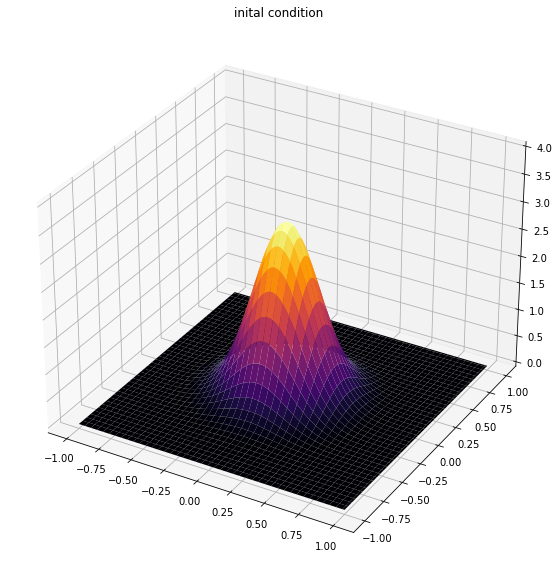

interactive(children=(IntSlider(value=10, description='time', max=20), Output()), _dom_classes=('widget-intera…

<function __main__.plot_3d_pred(time)>

In [191]:
import ipywidgets

plot_3d_ic()
ipywidgets.interact(plot_3d_pred, time=(0, 20 , 1))

In [126]:
import pickle
filename = 'models/2d_diffusion.sav'
#pickle.dump(results ,open(filename, 'wb'))